<a href="https://colab.research.google.com/github/sjyogesh23/YoutubeApiDS/blob/main/YoutubeAPI_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Get Data

In [197]:
import pandas as pd
import numpy as np

**For API:**
---

* Sign Up for Google Cloud Platform: Go to Google Cloud Platform and sign up with
your Google account.

* Create a New Project: In the Google Cloud Console, create a new project by clicking Select a Project and then New Project.

* Enable the API You Want to Use: In the Google Cloud Console, go to API & Services > Library and enable the API (e.g., Google Maps API, YouTube Data API, etc.).

* Create Credentials: Go to API & Services > Credentials, then create credentials (e.g., API Key, OAuth 2.0 Client ID, or Service Account) based on your needs.

* Create an api.txt File: Create a text file named api.txt on your local machine and paste your API Key (or credentials) into the file.

* Import the api.txt and Run the Program: In your program, import the api.txt file to load the API key or credentials and make API requests.

In [198]:
with open('api.txt', 'r') as file:
    api_key = file.read().strip()
developer_key = api_key

In [199]:
channel_id = ['UCRI00CwLZdLRCWg5BdDOsNw'] #CANADIANLAD

In [200]:
from googleapiclient.discovery import build
from IPython.display import JSON

youtube = build('youtube', 'v3', developerKey=developer_key)

request = youtube.channels().list(
    part="snippet,contentDetails,statistics",
    id=','.join(channel_id)
)
response = request.execute()

#JSON(response)

In [201]:
def get_channel_stats(youtube, channel_id):
  all_data = []
  request = youtube.channels().list(
    part="snippet,contentDetails,statistics",
    id=','.join(channel_id)
  )
  response = request.execute()
  for items in response['items']:
    data = {'channelName': items['snippet']['title'],
            'subscribers': items['statistics']['subscriberCount'],
            'views': items['statistics']['viewCount'],
            'totalVideos': items['statistics']['videoCount'],
            'playlistId': items['contentDetails']['relatedPlaylists']['uploads']
    }
    all_data.append(data)

  return pd.DataFrame(all_data)

get_channel_stats(youtube, channel_id)

,channelName,subscribers,views,totalVideos,playlistId
0,The Canadian Lad,1800000,471192211,316,UURI00CwLZdLRCWg5BdDOsNw


In [202]:
def get_video_ids(youtube, playlist_id, maxResults):
  video_id = []
  playlistId = playlist_id
  request = youtube.playlistItems().list(
    part="snippet,contentDetails",
    playlistId=playlist_id,
    maxResults = maxResults
  )
  response = request.execute()

  video_id.append(item['contentDetails']['videoId'] for item in response['items'])

  next_page_token = response.get('nextPageToken')
  while next_page_token is not None:
    request = youtube.playlistItems().list(
      part="contentDetails",
      playlistId=playlist_id,
      maxResults = maxResults,
      pageToken = next_page_token
    )
    response = request.execute()
    video_id += [item['contentDetails']['videoId'] for item in response['items']]
    next_page_token = response.get('nextPageToken')



  return video_id

video_id = get_video_ids(youtube, get_channel_stats(youtube, channel_id).playlistId[0], 50)
len(video_id)

268

In [203]:
def get_video_details(youtube, video_id):
  video_id = list(map(str, video_id))
  all_video_info = []
  for i in range(0, len(video_id), 50):
    request = youtube.videos().list(
      part="snippet,contentDetails,statistics",
      id=','.join(video_id[i:i+50])
    )
    response = request.execute()

    for video in response['items']:
      stats = {'snippet' : ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
              'statistics' : ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
              'contentDetails' : ['duration', 'definition', 'caption']
              }
      video_info = {}
      video_info['video_id'] = video['id']

      for k in stats.keys():
        for v in stats[k]:
          try:
            video_info[v] = video[k][v]
          except:
            video_info[v] = None

      all_video_info.append(video_info)

  return pd.DataFrame(all_video_info)


df1 = get_video_details(youtube, video_id)

#Data pre-processing

In [204]:
df = df1.copy()
df.head(1)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,ZPlBwYHn56k,The Canadian Lad,WHAT IF Season 2 Finale Gave Me a Headache!,Click the link https://t2m.io/MO_TheCanadianLa...,"[WHAT IF Season 2 Finale Gave Me a Headache, W...",2024-02-10T16:45:08Z,392435,18702,None,1406,PT5M16S,hd,false


In [205]:
df.drop(columns=['video_id','channelTitle','favouriteCount'], inplace=True)
df.head(1)

,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption
0,WHAT IF Season 2 Finale Gave Me a Headache!,Click the link https://t2m.io/MO_TheCanadianLa...,"[WHAT IF Season 2 Finale Gave Me a Headache, W...",2024-02-10T16:45:08Z,392435,18702,1406,PT5M16S,hd,false


In [206]:
df['publishedAt'] = pd.to_datetime(df['publishedAt'])

df['publishedAt_day'] = df['publishedAt'].dt.day
df['publishedAt_month'] = df['publishedAt'].dt.month
df['publishedAt_year'] = df['publishedAt'].dt.year
df['publishedAt_hr'] = df['publishedAt'].dt.hour
df['publishedAt_mins'] = df['publishedAt'].dt.minute
df['publishedAt_weekday'] = df['publishedAt'].dt.day_name()

cols = list(df.columns)
new_cols = ['publishedAt_day', 'publishedAt_month', 'publishedAt_year',
            'publishedAt_hr', 'publishedAt_mins','publishedAt_weekday']
for col in new_cols:
    cols.remove(col)
for i, col in enumerate(new_cols):
    cols.insert(3 + i, col)
df = df[cols]
df = df.drop(columns=['publishedAt'])

In [207]:
df.head(1)

,title,description,tags,publishedAt_day,publishedAt_month,publishedAt_year,publishedAt_hr,publishedAt_mins,publishedAt_weekday,viewCount,likeCount,commentCount,duration,definition,caption
0,WHAT IF Season 2 Finale Gave Me a Headache!,Click the link https://t2m.io/MO_TheCanadianLa...,"[WHAT IF Season 2 Finale Gave Me a Headache, W...",10,2,2024,16,45,Saturday,392435,18702,1406,PT5M16S,hd,false


In [208]:
!pip install isodate

In [209]:
import isodate
df['durationsecs'] = df['duration'].apply(lambda x: isodate.parse_duration(x))
df['durationsecs'] = df['durationsecs'].astype('timedelta64[s]').astype(int)

df['duration_days'] = df['durationsecs'] // (24 * 3600)
df['duration_hrs'] = (df['durationsecs'] % (24 * 3600)) // 3600
df['duration_secs'] = df['durationsecs'] % 60

df['duration_mins'] = (((df['durationsecs'] % 3600) // 60) + (df['duration_secs'] / 60)).round(2)

new_cols = ['duration_days', 'duration_hrs', 'duration_mins', 'duration_secs']
cols = list(df.columns)
for col in new_cols:
    cols.remove(col)
for i, col in enumerate(new_cols):
    cols.insert(12 + i, col)

df = df[cols]

In [210]:
df.head(1)

,title,description,tags,publishedAt_day,publishedAt_month,publishedAt_year,publishedAt_hr,publishedAt_mins,publishedAt_weekday,viewCount,likeCount,commentCount,duration_days,duration_hrs,duration_mins,duration_secs,duration,definition,caption,durationsecs
0,WHAT IF Season 2 Finale Gave Me a Headache!,Click the link https://t2m.io/MO_TheCanadianLa...,"[WHAT IF Season 2 Finale Gave Me a Headache, W...",10,2,2024,16,45,Saturday,392435,18702,1406,0,0,5.27,16,PT5M16S,hd,false,316


In [211]:
df = df.drop(columns=['duration', 'duration_days', 'duration_hrs', 'durationsecs', 'duration_secs'])
df.head(1)

,title,description,tags,publishedAt_day,publishedAt_month,publishedAt_year,publishedAt_hr,publishedAt_mins,publishedAt_weekday,viewCount,likeCount,commentCount,duration_mins,definition,caption
0,WHAT IF Season 2 Finale Gave Me a Headache!,Click the link https://t2m.io/MO_TheCanadianLa...,"[WHAT IF Season 2 Finale Gave Me a Headache, W...",10,2,2024,16,45,Saturday,392435,18702,1406,5.27,hd,false


In [212]:
df.dtypes

,0
title,object
description,object
tags,object
publishedAt_day,int32
publishedAt_month,int32
publishedAt_year,int32
publishedAt_hr,int32
publishedAt_mins,int32
publishedAt_weekday,object
viewCount,object


In [213]:
for col in ['viewCount', 'likeCount', 'commentCount']:
  df[col] = pd.to_numeric(df[col], errors="coerce")

df['caption'] = df['caption'].apply(lambda x: 1 if x == 'True' else 0)
df['definition'] = df['definition'].apply(lambda x: 1 if x == 'hd' else 0)
df.dtypes

,0
title,object
description,object
tags,object
publishedAt_day,int32
publishedAt_month,int32
publishedAt_year,int32
publishedAt_hr,int32
publishedAt_mins,int32
publishedAt_weekday,object
viewCount,int64


In [214]:
df['tagcount'] = df['tags'].apply(lambda x: 0 if x is None else len(x))
cols = list(df.columns)
cols.remove('tagcount')
cols.insert(3, 'tagcount')
df = df[cols]
df.head(1)

,title,description,tags,tagcount,publishedAt_day,publishedAt_month,publishedAt_year,publishedAt_hr,publishedAt_mins,publishedAt_weekday,viewCount,likeCount,commentCount,duration_mins,definition,caption
0,WHAT IF Season 2 Finale Gave Me a Headache!,Click the link https://t2m.io/MO_TheCanadianLa...,"[WHAT IF Season 2 Finale Gave Me a Headache, W...",11,10,2,2024,16,45,Saturday,392435,18702,1406,5.27,1,0


In [215]:
df['tags'] = df['tags'].fillna('')

#Data Analysis

In [216]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

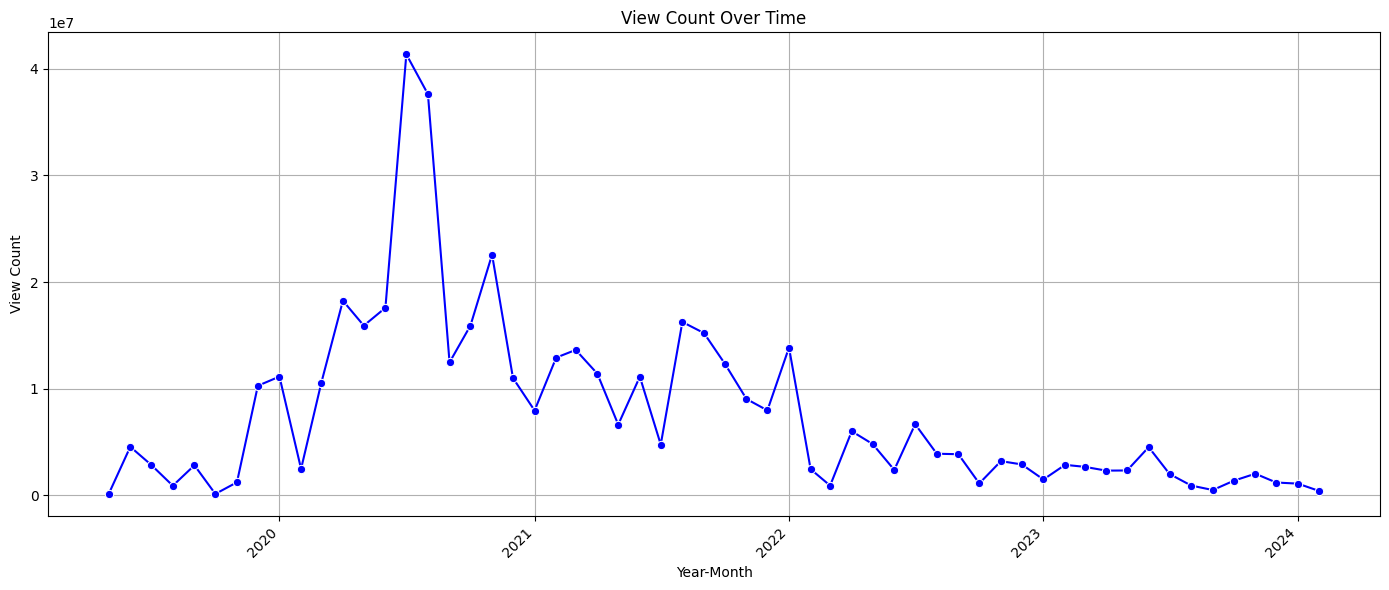

In [217]:
df['publishedAt_year'] = df['publishedAt_year'].astype(str)
df['publishedAt_month'] = df['publishedAt_month'].astype(str).str.zfill(2)

df['year_month'] = pd.to_datetime(df['publishedAt_year'] + '-' + df['publishedAt_month'])

monthly_stats = df.groupby('year_month')['viewCount'].sum().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_stats, x='year_month', y='viewCount', marker='o', color='blue')

plt.title('View Count Over Time')
plt.xlabel('Year-Month')
plt.ylabel('View Count')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

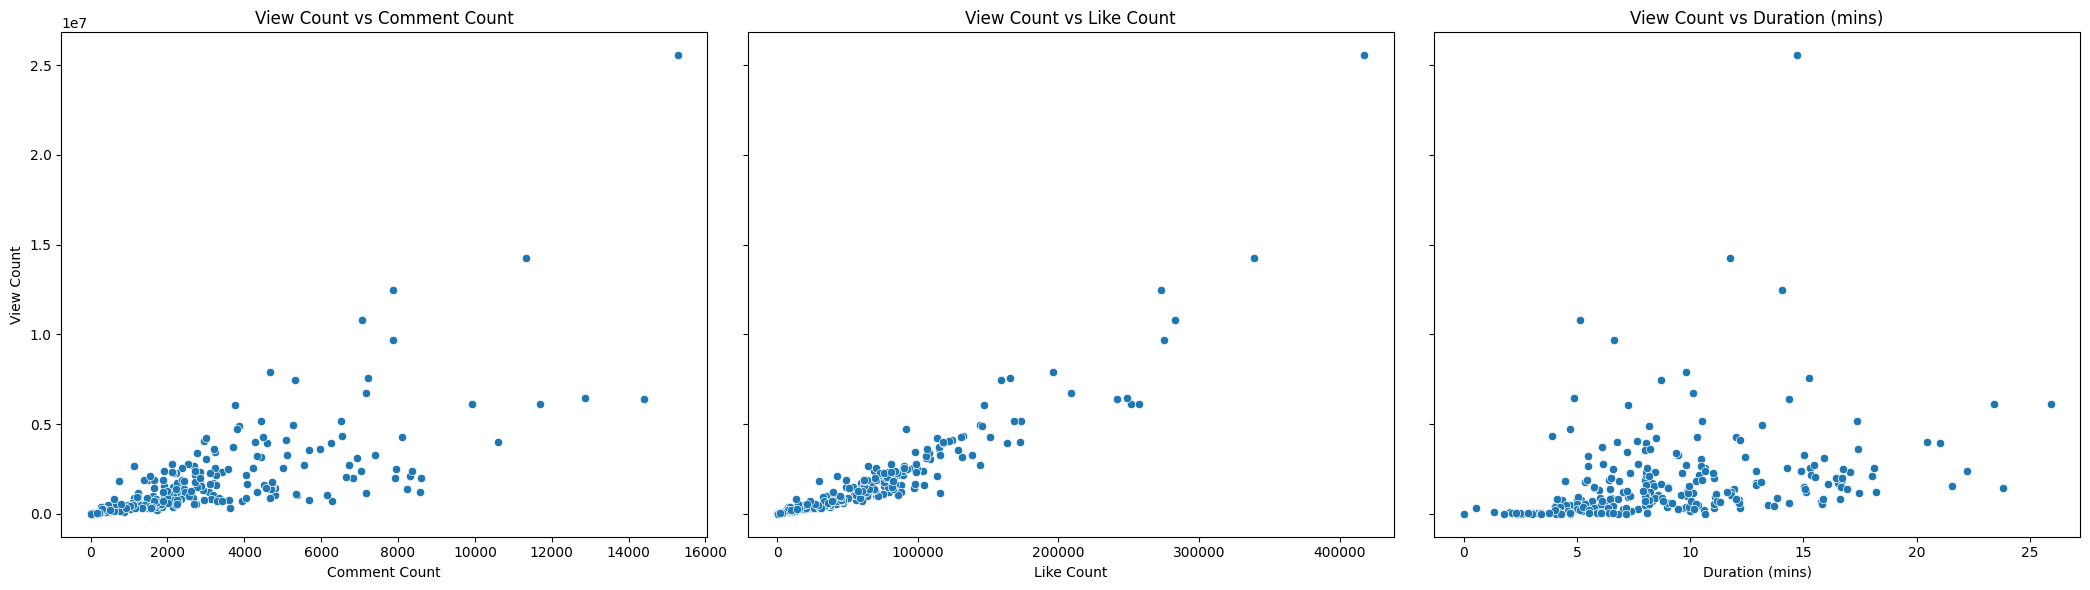

In [218]:
fig, axes = plt.subplots(1, 3, figsize=(21, 6), sharey=True)

sns.scatterplot(data=df, x='commentCount', y='viewCount', ax=axes[0])
axes[0].set_title('View Count vs Comment Count')
axes[0].set_xlabel('Comment Count')
axes[0].set_ylabel('View Count')

sns.scatterplot(data=df, x='likeCount', y='viewCount', ax=axes[1])
axes[1].set_title('View Count vs Like Count')
axes[1].set_xlabel('Like Count')
axes[1].set_ylabel('')

sns.scatterplot(data=df, x='duration_mins', y='viewCount', ax=axes[2])
axes[2].set_title('View Count vs Duration (mins)')
axes[2].set_xlabel('Duration (mins)')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

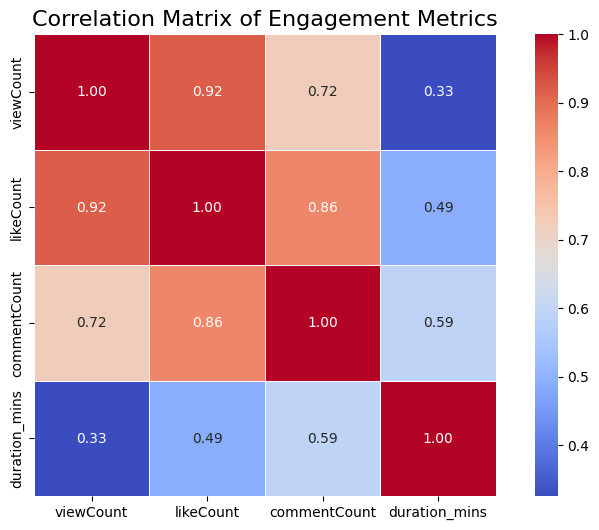

In [219]:
cols_to_correlate = ['viewCount', 'likeCount', 'commentCount', 'duration_mins']
corr_matrix = df[cols_to_correlate].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Correlation Matrix of Engagement Metrics", fontsize=16)
plt.show()

<ipython-input-220-854ca01b21cc>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', 7).colors


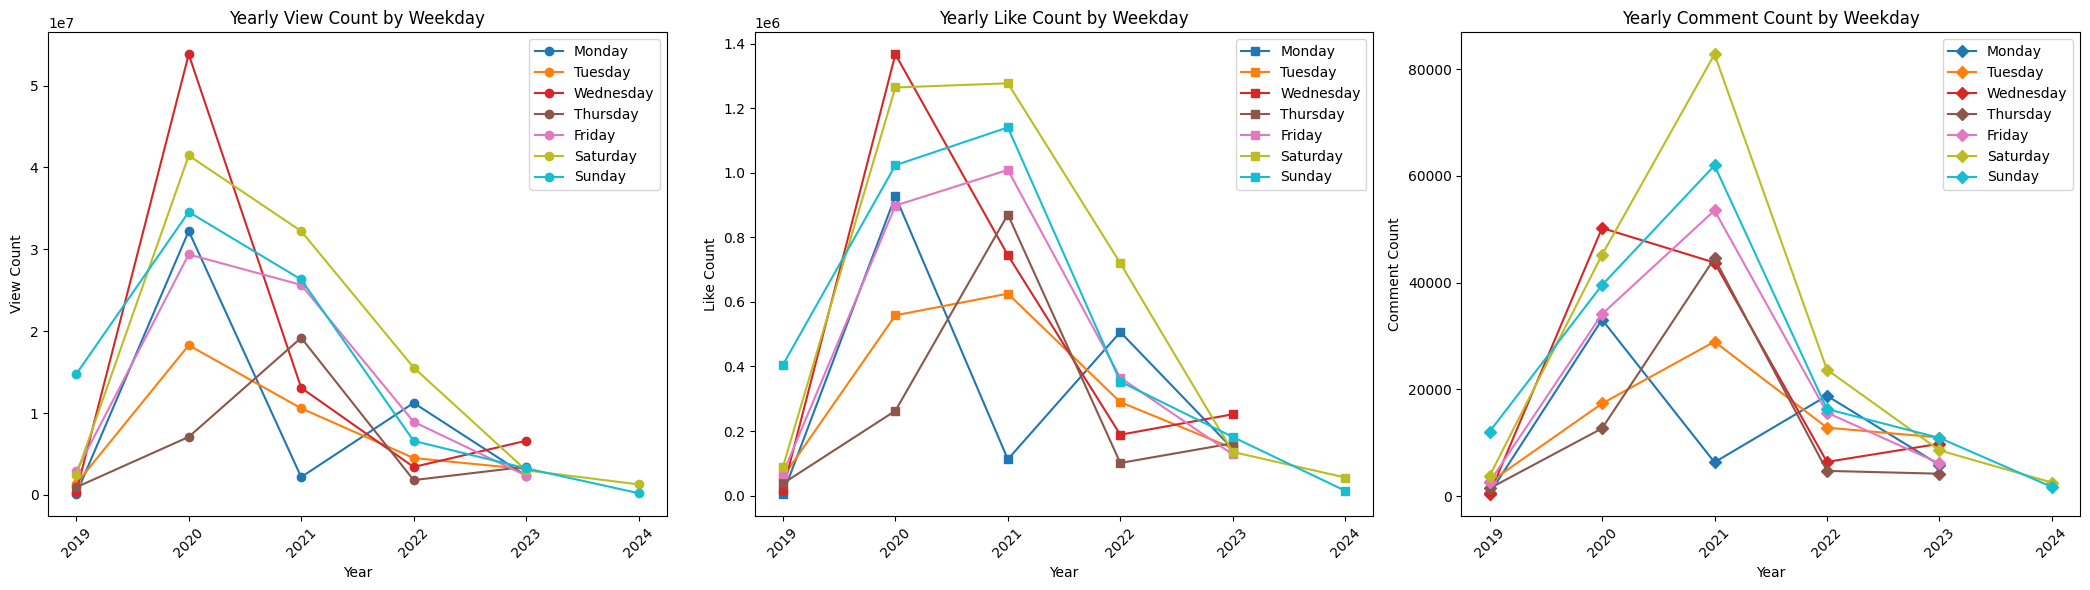

In [220]:
weekly_stats = df.groupby(['publishedAt_year', 'publishedAt_weekday'])[['viewCount', 'likeCount', 'commentCount']].sum().reset_index()

weekly_stats_pivot = weekly_stats.pivot_table(
    index='publishedAt_year',
    columns='publishedAt_weekday',
    values=['viewCount', 'likeCount', 'commentCount'],
    aggfunc='sum'
)

weekly_stats_pivot.index = pd.to_numeric(weekly_stats_pivot.index, errors='coerce')

weekly_stats_pivot = weekly_stats_pivot.dropna(how='all')

colors = cm.get_cmap('tab10', 7).colors
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

for i, day in enumerate(weekday_order):
    if day in weekly_stats_pivot['viewCount']:
        y_vals = pd.to_numeric(weekly_stats_pivot['viewCount'][day], errors='coerce')
        axes[0].plot(weekly_stats_pivot.index, y_vals, label=day, color=colors[i], marker='o')
axes[0].set_title('Yearly View Count by Weekday')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('View Count')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend()

for i, day in enumerate(weekday_order):
    if day in weekly_stats_pivot['likeCount']:
        y_vals = pd.to_numeric(weekly_stats_pivot['likeCount'][day], errors='coerce')
        axes[1].plot(weekly_stats_pivot.index, y_vals, label=day, color=colors[i], marker='s')
axes[1].set_title('Yearly Like Count by Weekday')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Like Count')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()

for i, day in enumerate(weekday_order):
    if day in weekly_stats_pivot['commentCount']:
        y_vals = pd.to_numeric(weekly_stats_pivot['commentCount'][day], errors='coerce')
        axes[2].plot(weekly_stats_pivot.index, y_vals, label=day, color=colors[i], marker='D')
axes[2].set_title('Yearly Comment Count by Weekday')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Comment Count')
axes[2].tick_params(axis='x', rotation=45)
axes[2].legend()

plt.tight_layout()
plt.show()

In [221]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

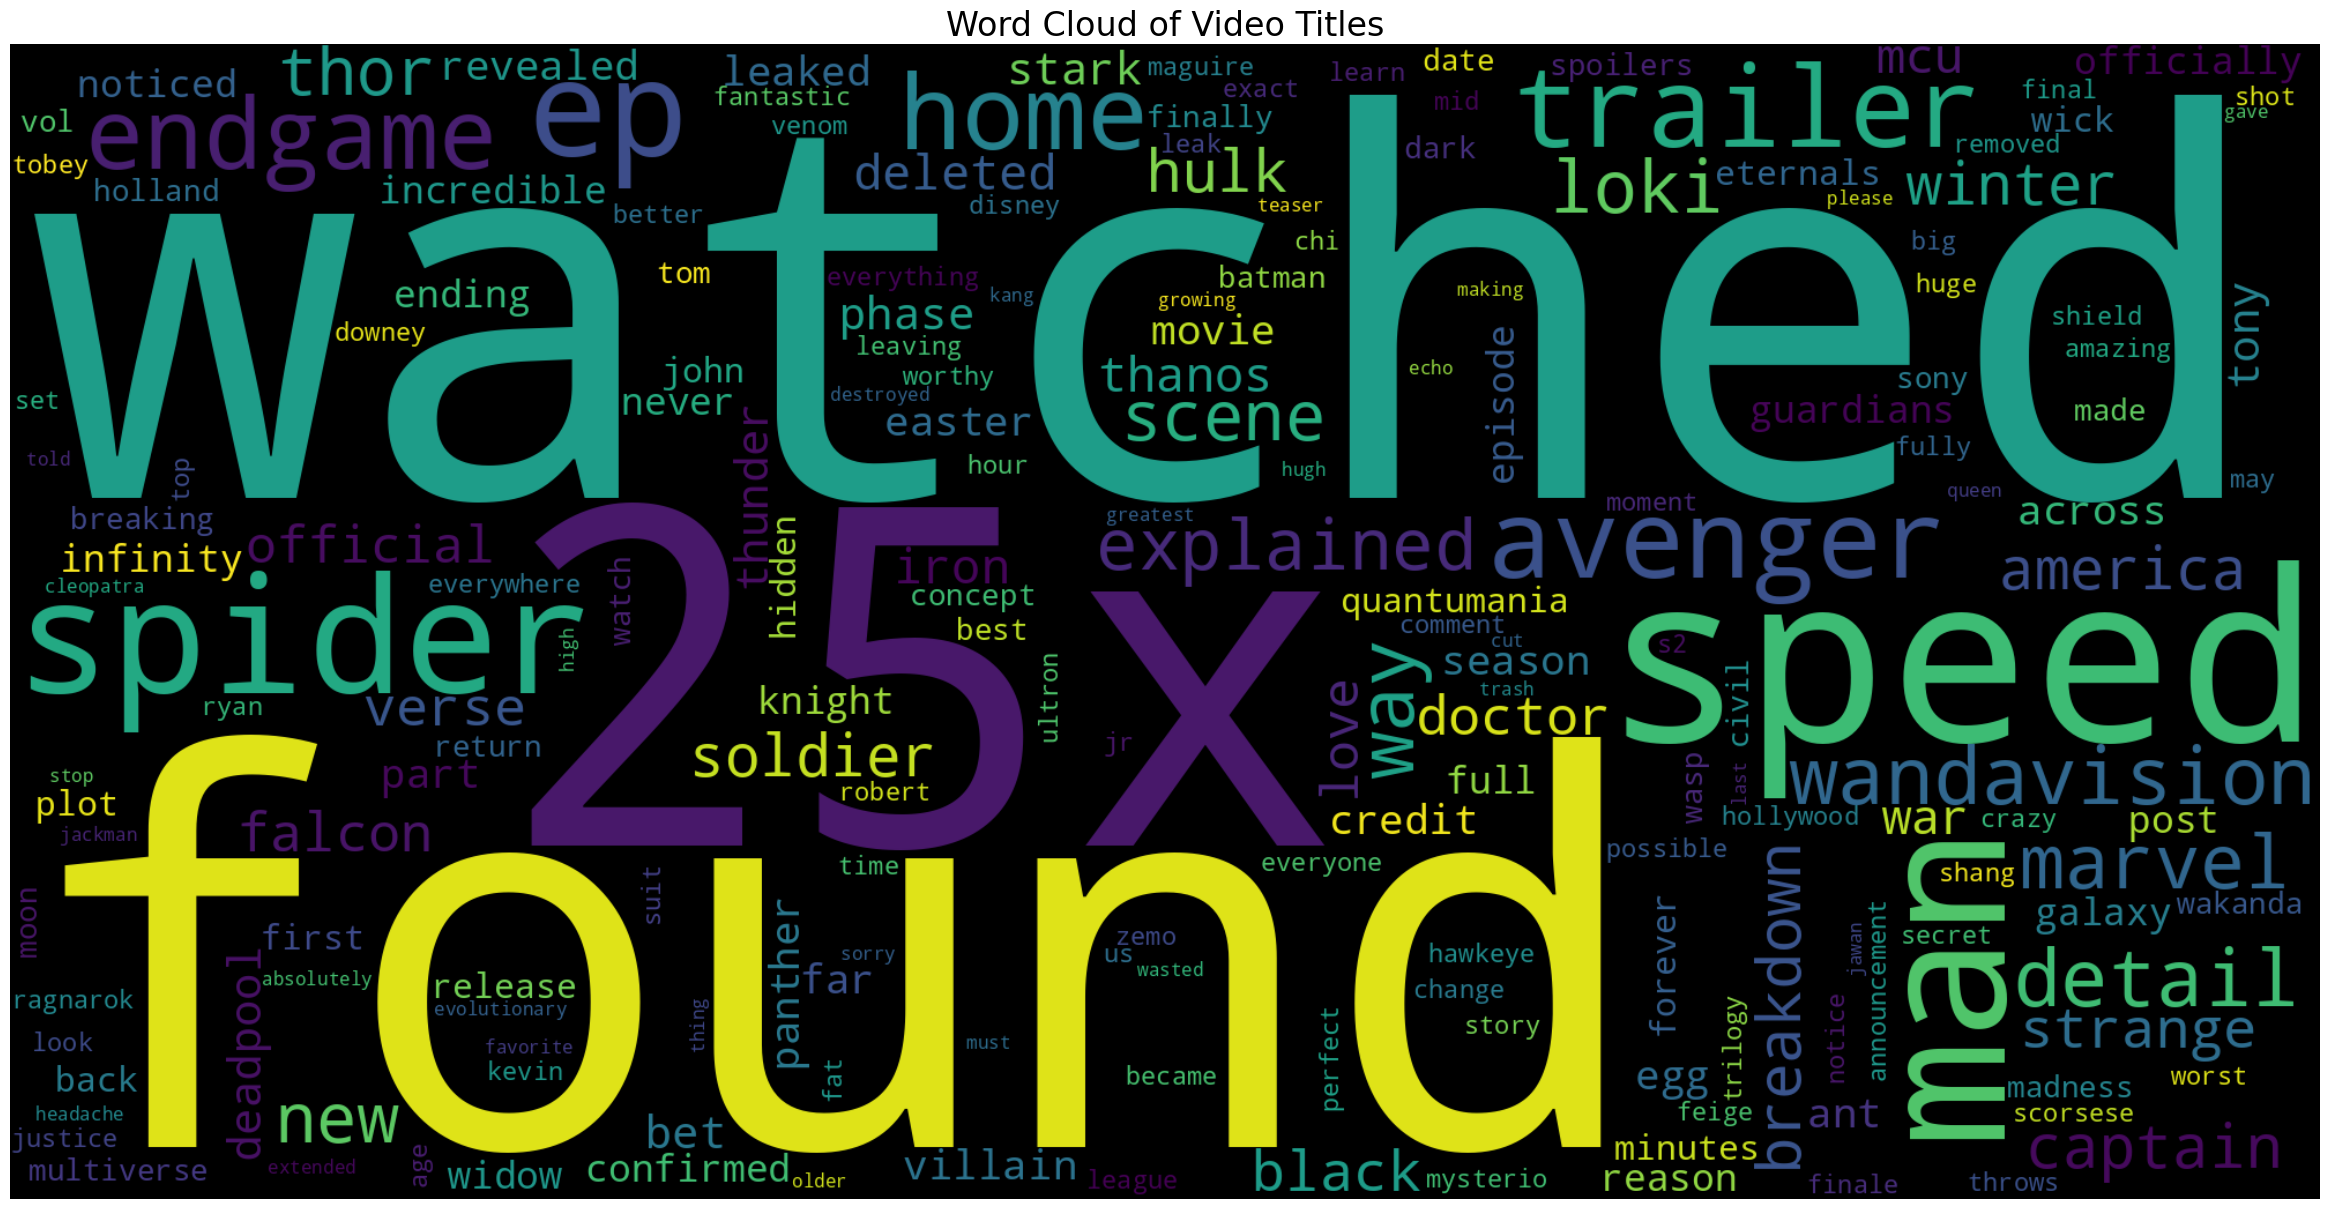

In [222]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

stop_words = set(stopwords.words('english'))
all_title_words = ' '.join([
    word.lower()
    for title in df['title'].dropna()
    for word in str(title).split()
    if word.lower() not in stop_words
])

wordcloud = WordCloud(
    width=2000,
    height=1000,
    background_color='black',
    colormap='viridis',
    collocations=False
).generate(all_title_words)

plt.figure(figsize=(30, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Video Titles", fontsize=24)
plt.show()

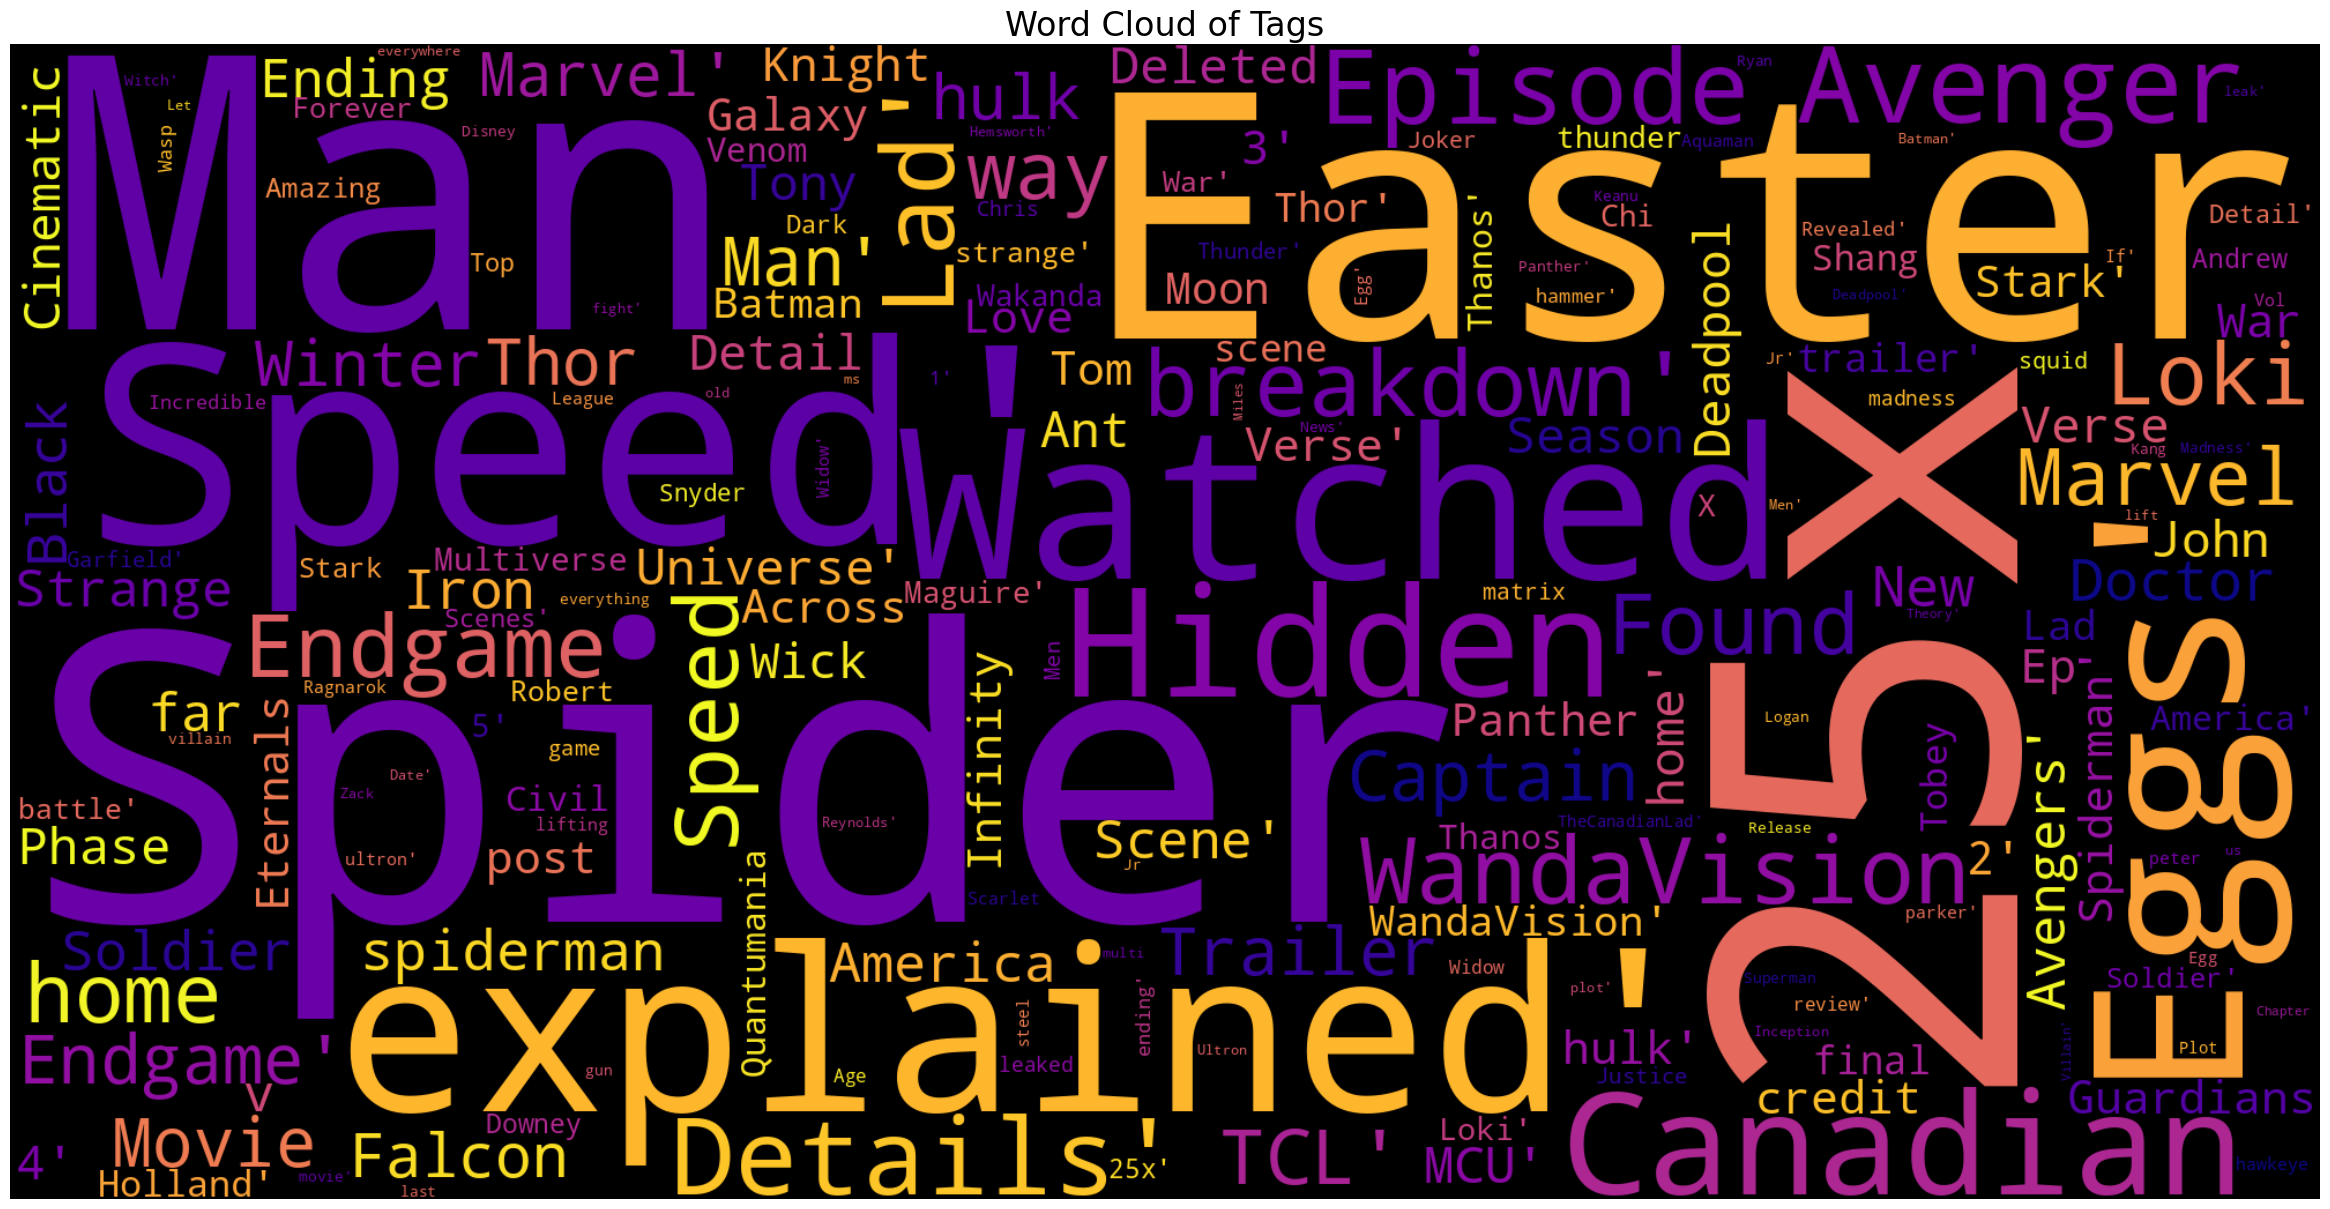

In [223]:
all_tags = ' '.join(df['tags'].dropna().astype(str).tolist())

wordcloud = WordCloud(
    width=2000,
    height=1000,
    background_color='black',
    colormap='plasma',
    collocations=False
).generate(all_tags)

plt.figure(figsize=(30, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Tags", fontsize=24)
plt.show()